In [2]:
# Essential
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
import gmaps 

# Statistics
from scipy.stats import norm
from scipy import stats
from scipy.special import boxcox, inv_boxcox
from statsmodels.stats.outliers_influence import variance_inflation_factor

#Models
from xgboost import XGBRegressor
from sklearn.linear_model import ElasticNet, Lasso, BayesianRidge, LassoLarsIC, Ridge, HuberRegressor, RidgeCV
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor

# Evaluation
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import KFold

#Misc
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve, ShuffleSplit, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from pprint import pprint
import shap
import warnings
warnings.filterwarnings('ignore')

shap.initjs()

In [2]:
df = pd.read_csv('travelio.csv', index_col = 0)

# Data Cleaning

In [3]:
print(df.isna().sum())
print(f"Number of column before cleaning: {df.shape[0]}")

Name               0
Total Bedroom      0
Total Bathroom     0
Apart Size         0
Max Capacity      33
Max Watt          28
Address           33
Swim Pool          0
Rating             0
Total Review      23
Furnish Type       0
Price              0
dtype: int64
Number of column before cleaning: 806


It seems that there are some rows that are missing some important informations. Since it will be really hard to fill in those data with appropriate value we will just remove them instead.

In [4]:
# Remove rows that have no address
df2 = df.dropna(subset = ['Address'])

# Because our job is to predict apartment prices from the given specifications it wouldn't make sense to actually include 'Rating' and
# 'Total Review' since those variables can only be obtained when the apartment is already listed along with its price.
df2.drop(columns = ['Rating', 'Total Review'], inplace = True)

In [5]:
print(df2.isna().sum())
print(f"Number of column after cleaning: {df2.shape[0]}")

Name              0
Total Bedroom     0
Total Bathroom    0
Apart Size        0
Max Capacity      0
Max Watt          0
Address           0
Swim Pool         0
Furnish Type      0
Price             0
dtype: int64
Number of column after cleaning: 773


In [6]:
df2.reset_index(drop=True, inplace=True)

In [7]:
# Clean the price column from the dataset and extract only the integer
df2['Price'] = df2['Price'].str.replace(r'\D+', '')
df2['Price'] = df2['Price'].astype(int)

df2['Apart Size'] = df2['Apart Size'].str.replace(r'\D+', '')
df2['Apart Size'] = df2['Apart Size'].astype(int)

df2['Max Capacity'] = df2['Max Capacity'].str.replace(r'\D+', '')
df2['Max Capacity'] = df2['Max Capacity'].astype(int)

df2['Max Watt'] = df2['Max Watt'].str.replace(r'\D+', '')
df2['Max Watt'] = df2['Max Watt'].astype(int)

df2['Total Bedroom'].replace({"Studio": 0}, inplace = True)
df2['Total Bedroom'] = df2['Total Bedroom'].astype(int)

In [8]:
df2.info()
df2.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 773 entries, 0 to 772
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Name            773 non-null    object
 1   Total Bedroom   773 non-null    int32 
 2   Total Bathroom  773 non-null    int64 
 3   Apart Size      773 non-null    int32 
 4   Max Capacity    773 non-null    int32 
 5   Max Watt        773 non-null    int32 
 6   Address         773 non-null    object
 7   Swim Pool       773 non-null    int64 
 8   Furnish Type    773 non-null    object
 9   Price           773 non-null    int32 
dtypes: int32(5), int64(2), object(3)
memory usage: 45.4+ KB


,Total Bedroom,Total Bathroom,Apart Size,Max Capacity,Max Watt,Swim Pool,Price
count,773.000000,773.000000,773.000000,773.000000,773.000000,773.000000,7.730000e+02
mean,1.349288,1.179819,51.058215,2.915912,2545.725744,0.878396,6.816667e+06
std,0.989382,0.413511,32.613103,1.064947,2016.470858,0.478243,4.224733e+06
min,0.000000,1.000000,14.000000,1.000000,1.000000,-1.000000,1.799999e+06
25%,0.000000,1.000000,31.000000,2.000000,1300.000000,1.000000,4.199391e+06
50%,2.000000,1.000000,38.000000,3.000000,2200.000000,1.000000,5.281957e+06
75%,2.000000,1.000000,61.000000,4.000000,3500.000000,1.000000,8.206249e+06
max,3.000000,4.000000,297.000000,8.000000,21000.000000,1.000000,3.777713e+07


# EDA

<AxesSubplot:xlabel='Price', ylabel='Density'>

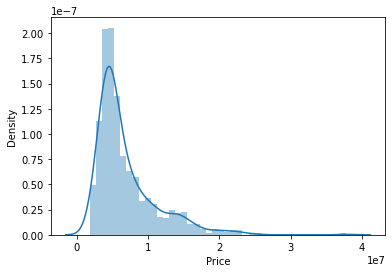

In [9]:
sb.distplot(df2['Price'])

In [51]:
print("Skewness: %f" % df2['Price'].skew())
print("Kurtosis: %f" % df2['Price'].kurt())


Skewness: 1.993154
Kurtosis: 5.708796


Skewness can indicate wether the data follow the normal distribution, in most cases a skewed data can actually lead to a worst performance of the model. Most model like linear regression works better with a data that follows the normal distribution. 

On the other hand, kurtosis indicate how heavy or light tailed the data is which is correlated to the presence of outliers. A kurtosis higher than 3 (normal distribution) normally indicate the presence of outliers and have a very peaked shape.

<AxesSubplot:xlabel='Apart Size', ylabel='Count'>

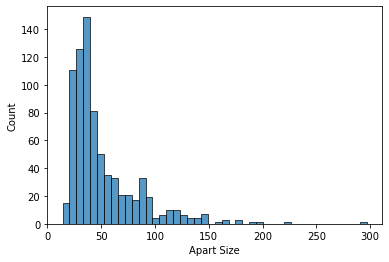

In [10]:
sb.histplot(data = df2['Apart Size'] )

In [53]:
print("Skewness: %f" % df2['Apart Size'].skew())
print("Kurtosis: %f" % df2['Apart Size'].kurt())

Skewness: 2.195653
Kurtosis: 7.163900


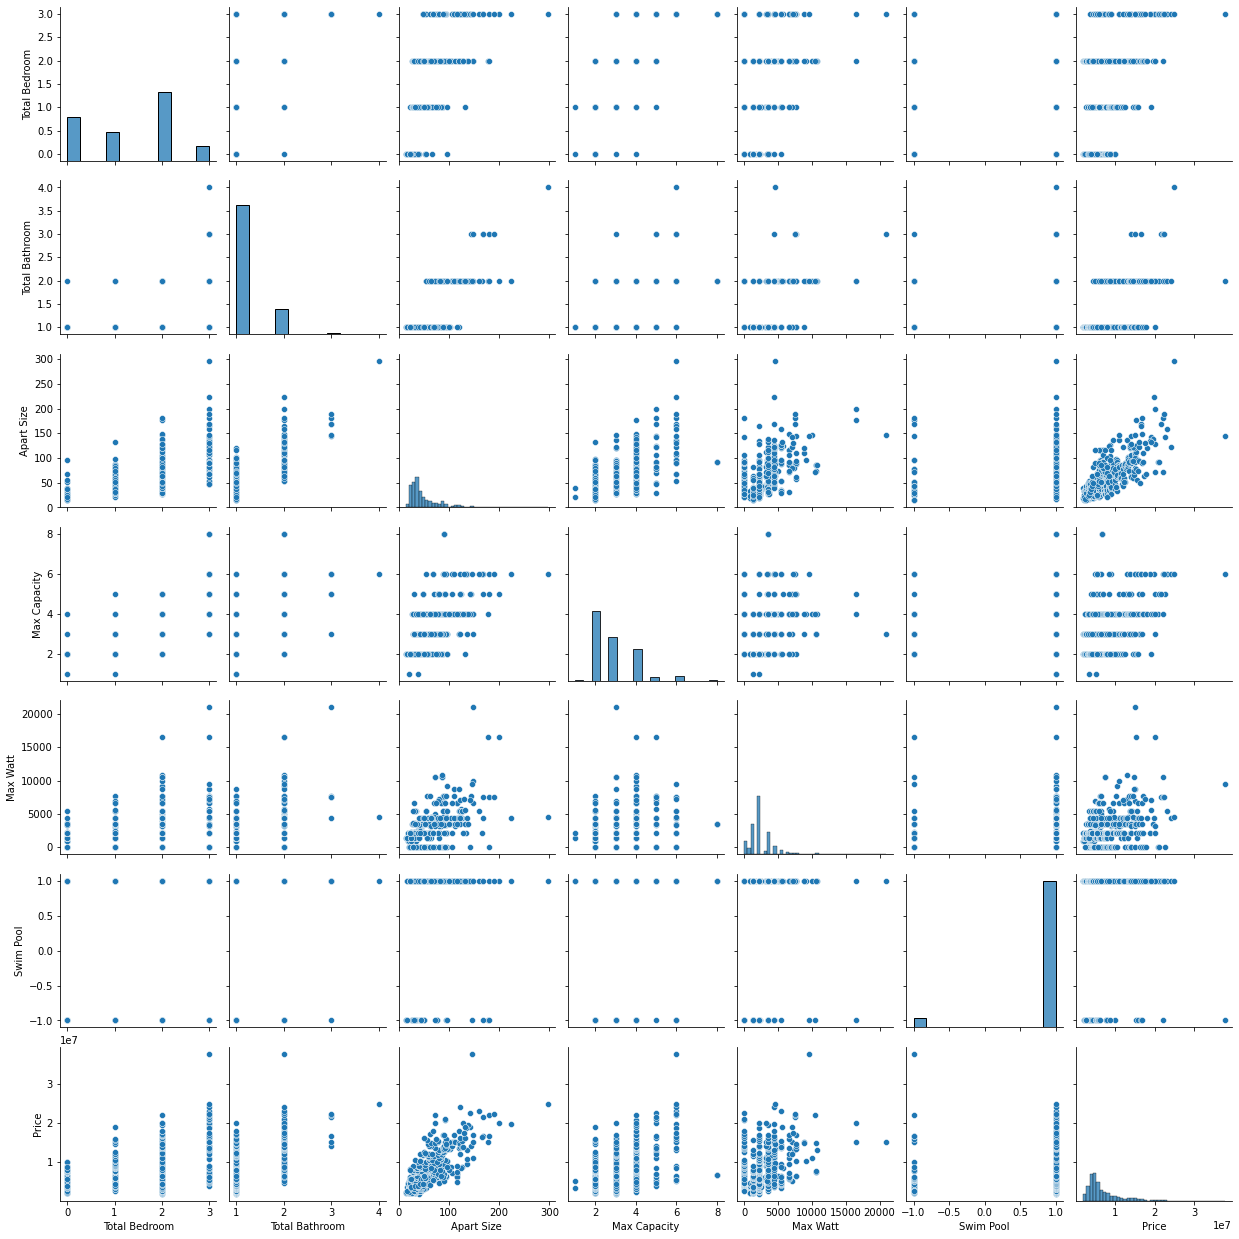

In [54]:
sb.pairplot(df2)
plt.rcParams["figure.figsize"] = [16,9]
plt.show()

Based on our scatter plot there is sign of outliers in Apart Size, we will investigate it further along the line.

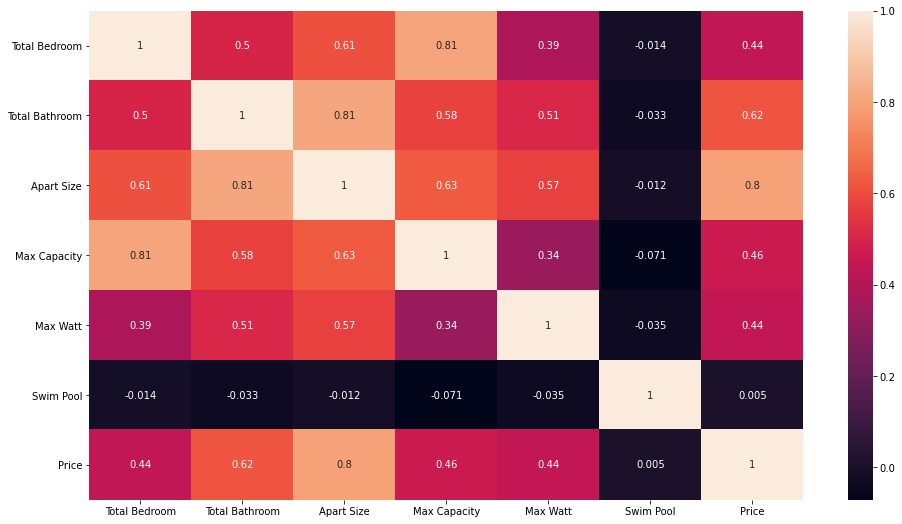

In [55]:
fig, ax = plt.subplots(figsize=(16, 9))
corr_matrix = df2.corr()
sb.heatmap(data = corr_matrix, annot = True)
plt.show()

The heatmap shows sign of multicollinearity between 'Total Bedroom', 'Total Bathroom', 'Apart Size', and 'Max Capacity'. We many need to remove some of these variables. The heatmap also shows a strong linear correlation between our target variable 'Price' and 'Apart Size' so its definitely a feature we want to keep.

In [4]:
# Checkpoint
# df2.to_csv('travelio2.csv', index=True)
df2 = pd.read_csv('travelio2.csv', index_col = 0)

## Geocoding

In [ ]:
import geopy
from geopy.extra.rate_limiter import RateLimiter
from geopy.exc import GeocoderTimedOut
from geopy.geocoders import GoogleV3
from geopy.extra.rate_limiter import RateLimiter

geolocator = GoogleV3(api_key = '***************')

In [67]:
# Delay 1 second between each call to reduce the probability of a time out
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

df2['location'] = df2['Address'].apply(geocode)

In [66]:
df2['point'] = df2["location"].apply(lambda loc: tuple(loc.point) if loc else None)

In [55]:
a= df2[df2['location'].isnull()].index.tolist()
df2.iloc[a]
# It seems that there are some addresses that can't be detected by Google Maps API, so I decided to manually look up those addresses on
# Google Map by using different keywords like apartment name. I then replaces the undetected addresses with correct ones.

,Name,Total Bedroom,Apart Size,Max Watt,Address,Swim Pool,Furnish Type,Price,lat,lon,location,kecamatan


I also found that there are quite a few Addresses with incorrect location so I performed some additional fixing by manually replacing incorrect locations on the csv file.

In [ ]:
# Unload the points to latitude and longtitude
df2[['lat', 'lon', 'altitude']] = pd.DataFrame(df2['point'].to_list(), index=df2.index)

Now that we have longitude and altitude of each address we don't need location and point features anymore. 

We should also remove altitude
because Google API require us to use the latitude api if we want to get latitude for a specific location. We won't go that far since its unlikely that altitude will play any significant roles on Jakarta apartments rental prices.

In [78]:
df2.drop(columns = ['point', 'altitude'], inplace = True)

In [5]:
# Checkpoint
# df2.to_csv('travelio3.csv', index=True)
df2 = pd.read_csv('travelio3.csv', index_col = 0)

In [6]:
gmaps.configure(api_key='*********')

fig = gmaps.figure()
heatmap_layer = gmaps.heatmap_layer(
  df2[['lat','lon']],
  weights= df2['Price'],
  max_intensity = 100000000,
  point_radius= 10.0
)

fig.add_layer(heatmap_layer)
fig

Figure(layout=FigureLayout(height='420px'))

Based on our geographical analysis we can see that apartment prices tend to be higher when located in Central and South Jakarta region. This is as expected as those 2 region are known as elite places in Jakarta with lots of facilities and well-developed infrastructures.

# Feature Engineering

## Multicollinearity

Since we are going to run a multiple linear regression model on this dataset it is important to avoid multicollinearity. When there is a correlation between the independent variables it can becomes difficult for the model to estimate the relationship between each independent variable and the dependent variable independently because the independent variables tend to change in unison.

Here are some algorithms that are effected by multicollinearity Linear Regression, Logistic Regression, KNN, and Naive Bayes.

It seems that 'Max Capacity' has a strong correlation with total Bedroom which indicate some multicollinearity. If we think about it, it makses sense because max capacity of an apartment is probably based on the number of bedroom and size of apartment.

In [5]:
df2.drop(columns = "Max Capacity", inplace = True)

In [6]:
X_variables = df2[['Total Bedroom', 'Total Bathroom', 'Apart Size', 'Max Watt']]

vif_data = pd.DataFrame()
vif_data["feature"] = X_variables.columns
vif_data["VIF"] = [variance_inflation_factor(X_variables.values, i) for i in range(len(X_variables.columns))]

In [7]:
vif_data

,feature,VIF
0,Total Bedroom,4.468788
1,Total Bathroom,9.512638
2,Apart Size,10.778528
3,Max Watt,3.888674


As seen on the heatmap and vif Total Bathroom and Apart Size seems highly correlated so we can remove one of them. I decided to remove Total Bathroom as it has a lower correlation with the target variable 'Price'.

In [8]:
df2.drop(columns = "Total Bathroom", inplace = True)

In [9]:
X_variables = df2[['Total Bedroom','Apart Size', 'Max Watt']]

vif_data = pd.DataFrame()
vif_data["feature"] = X_variables.columns
vif_data["VIF"] = [variance_inflation_factor(X_variables.values, i) for i in range(len(X_variables.columns))]
vif_data

,feature,VIF
0,Total Bedroom,4.280758
1,Apart Size,6.205461
2,Max Watt,3.688159


In [3]:
# Checkpoint
# df2.to_csv('travelio4.csv', index = True)
df2 = pd.read_csv('travelio4.csv', index_col = 0)

## Get Sub-Districts
I will try to obtain the list of districts and sub-districts each apartment is located in. This might help with our prediction since we now that some districts are more elite than others, these elite districts tend to have higher property prices.

In [4]:
import requests
from bs4 import BeautifulSoup

URL = "https://id.wikipedia.org/wiki/Daftar_kecamatan_dan_kelurahan_di_Daerah_Khusus_Ibukota_Jakarta"
page = requests.get(URL)

soup = BeautifulSoup(page.content, "html.parser")
table = soup.find_all("tbody")

In [5]:
kecamatan = []
element = soup.select("td:nth-of-type(2)")
for idx, item in enumerate(element):
    if idx >5 and idx <48:
        kecamatan.append(item.text)

In [6]:
old = ['Kelapa Gading', 'Pasar Minggu', 'Pasar Rebo', 'Tanjung Priok', 'Kebayoran Lama', 'Kebayoran Baru', 'Mampang Prapatan', 'Kebon Jeruk']
new = ['Klp. Gading', 'Ps. Minggu', 'Ps. Rebo', 'Tj. Priok', 'Kby. Lama', 'Kby. Baru','Mampang Prpt', 'Kb. Jeruk']
for i, val in enumerate(old):
    idx = kecamatan.index(val)
    kecamatan[idx] = new[i]
kecamatan.append('Setia Budi')
kecamatan.append('Pd. Aren')
kecamatan.append('Kebon Jeruk')

In [7]:
# Create a function that will return the district an address belongs in, and apply that function to every row in the data
def kec(val):
    return next((x for x in kecamatan if x.lower() in val.lower()), None)
df2['kecamatan'] = df2['location'].apply(kec)

In [10]:
a = df2[df2['kecamatan'].isnull()].index.tolist()
empty_rows = df2.iloc[a].copy()

In [11]:
print(a)

[96, 97, 110, 164, 172, 190, 233, 235, 240, 243, 249, 573, 627, 641, 646, 668, 682, 688, 689, 743]


It seems that some locations are incomplete (they don't have district in them) due to the geocoding by Google API, so we will just use our original Address that we obtain from the travelio website instead.

In [12]:
rev = empty_rows.index.to_list()

def kec(val):
    return next((x for x in kecamatan if x.lower() in val.lower()), None)
df2['kecamatan'].iloc[rev] = df2['Address'].iloc[rev].apply(kec)

df2.replace({'Setia Budi' : 'Setiabudi'}, inplace=True)
df2.replace({'Kebon Jeruk' : 'Kb. Jeruk'}, inplace=True)

In [13]:
a= df2[df2['kecamatan'].isnull()].index.tolist()
len(df2.iloc[a])

0

Great! We've filled in all the districts for each corresponding apartment. Now lets try to see the average price of housing for each district.

In [14]:
df2.groupby(['kecamatan']).Price.agg('mean').sort_values(ascending = False)
# res = df_agg.apply(lambda x: x.sort_values(ascending=True))

kecamatan
Kby. Baru            1.806751e+07
Mampang Prpt         1.523673e+07
Setiabudi            1.106564e+07
Kby. Lama            1.089827e+07
Menteng              9.563951e+06
Cilandak             8.927184e+06
Pancoran             8.576855e+06
Tanah Abang          7.904778e+06
Pd. Aren             7.735000e+06
Gambir               6.446666e+06
Kb. Jeruk            6.430905e+06
Pesanggrahan         6.270067e+06
Tebet                5.843505e+06
Grogol Petamburan    5.749463e+06
Senen                5.660513e+06
Kembangan            5.596787e+06
Kemayoran            5.463723e+06
Tambora              5.285560e+06
Kalideres            5.280624e+06
Ps. Minggu           5.273301e+06
Pademangan           5.096884e+06
Kramat Jati          4.981074e+06
Penjaringan          4.865202e+06
Jatinegara           4.780318e+06
Klp. Gading          4.778076e+06
Sawah Besar          4.761854e+06
Ps. Rebo             4.500187e+06
Taman Sari           4.375700e+06
Cengkareng           4.273109e+06
Cemp

As we can see, the top 5 districts with the highest apartment price in average comes from district located in South and Central Jakarta. This make sense since we know that places in South and Central Jakarta have a higher living cost and are more elite compare to other region.

## A bit more cleaning

While I was extracting district for each row I've also discovered that some of the Max Watt have only a value of 1, it seems that I forgot to clean these rows. These 1's indicate that the scraper are unable to extract the max watt information during the web scraping process.

So, I'll have to perform some imputing. To impute this data I've decided to use multivariate imputing from Sk-Learn which uses a Bayesian Ridge Regression to predict the most likely outcome of the missing data using other features in the data. We basically treat Max Watt as the dependent variables.

This should result to a more accurate imputation compared to the univariate imputation in which only a single value obtain by calculating the mean or median is use to fill in all the missing data.

In [130]:
# Checkpoints
# df2.to_csv('travelio5.csv', index = True)
df2 = pd.read_csv('travelio5.csv', index_col=0)

In [131]:
df2['Max Watt'] = df2['Max Watt'].replace(1, np.NaN)
df2['Max Watt'].isna().sum()

66

In [132]:
# Here I created a temporary dataframe and fill it with features that have highest correlations with Max Watt.
# These features will act as the independent/predictors variable to determine the most likely value for Max Watt.

# I pick these features as predictor because they have the highest correlation with Max Watt
dftemp = df2[['Total Bedroom', 'Apart Size', 'Max Watt', 'Price']].copy()

In [133]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge

imputer = IterativeImputer()
imputer.fit(dftemp)
df_trans = imputer.transform(dftemp)
df_trans = pd.DataFrame(df_trans, columns=dftemp.columns)

In [136]:
df2['Max Watt'] = df_trans['Max Watt']
df2['Max Watt'] = df2['Max Watt'].astype(int)

In [11]:
# Checkpoints
# df2.to_csv('travelio6.csv', index = True)
df2 = pd.read_csv('travelio6.csv', index_col = 0)

## Outliers

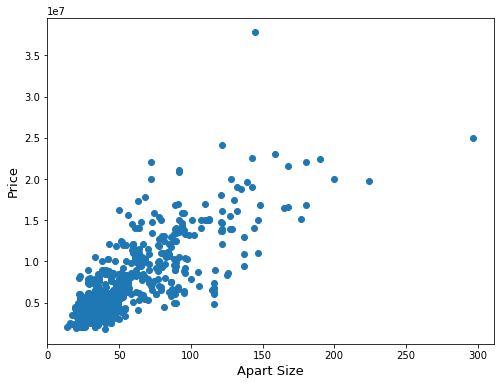

In [12]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(x = df2['Apart Size'], y = df2['Price'])
plt.ylabel('Price', fontsize=13)
plt.xlabel('Apart Size', fontsize=13)
plt.show()

We can see that there is one apartment with a very high price despite its fairly average size, we can assume that it is located in a very elite location but unfortunately is simply way to high and unlikely in a real life scenario so we can simply treat it as an outlier and remove that data point.

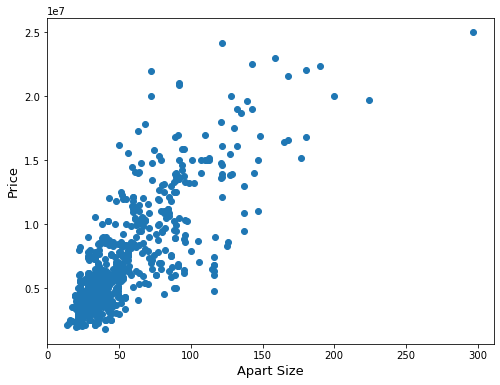

In [13]:
# Delete Outliers
df2 = df2.drop(df2[df2['Price'] > 35000000].index)
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(x = df2['Apart Size'], y = df2['Price'])
plt.ylabel('Price', fontsize=13)
plt.xlabel('Apart Size', fontsize=13)
plt.show()

## Handling Categorical Data

In [29]:
df2.reset_index(drop=True, inplace=True)

In [30]:
# Clean some row
df2['Furnish Type'] = df2['Furnish Type'].replace('5', "Unfurnished")

In [31]:
# Dummy Encoding Furnish Type because it is a nominal variable
dummy_furnished = pd.get_dummies(df2[['Furnish Type', 'kecamatan']], prefix='', prefix_sep='')
df2 = pd.merge(
    left=df2,
    right=dummy_furnished,
    left_index=True,
    right_index=True,
)
df2.drop(columns = ["Furnish Type", 'kecamatan'], inplace = True)

## Normality

To check for the distribution and normality of our features I'll be plotting a distribution plot and a normal probability plot / Q-Q plot.

Features with normal distribution should have a symemtrical bell shape curve in the distribution plot and data distribution should closely follow the diagonal in the Q-Q plot.

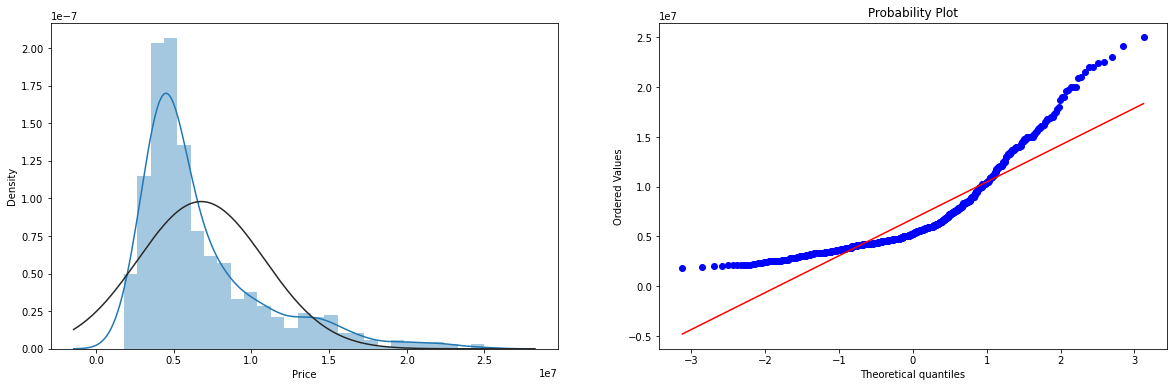

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))
sb.distplot(df2['Price'], fit=norm, ax=ax1)
res = stats.probplot(df2['Price'], plot=ax2)

After removing the outliers in 'Sales Price' we can see that the kurtosis becomes closer to that of a normal distribution. However we can still see some skewness in our data so we can fix it using box cox transformation. We will also apply it to "apart size".

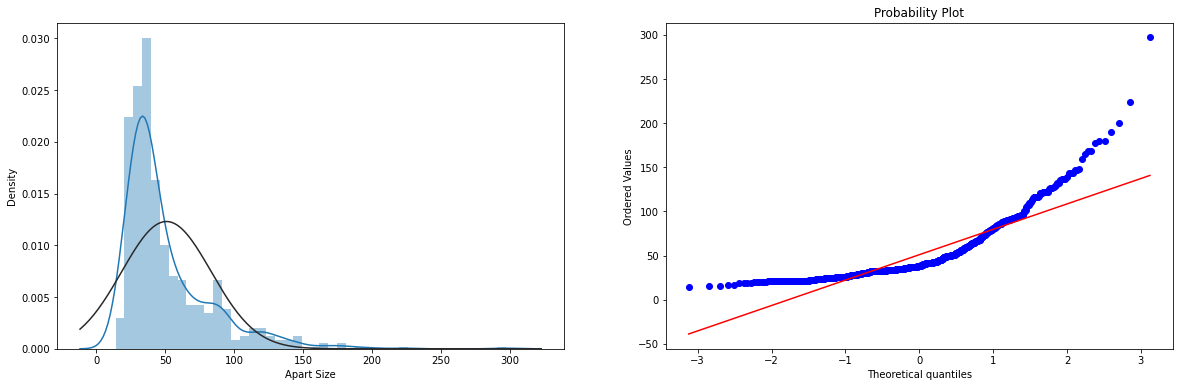

In [27]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))
sb.distplot(df2['Apart Size'], fit=norm, ax=ax1)
res = stats.probplot(df2['Apart Size'], plot=ax2)

We can analyze that the Apartment rental pricing are skewed to the left and has a heavy tail distribution.

### Log Transform

To fix the skewness and transform our data into a more normal distribution I'm going to perform a log transformation. The reason I did not go with box cox transformation is because it will be difficult to reverse transform our price estimate during the final production.

In [29]:
df2['Apart Size'] = np.log(df2['Apart Size'])
df2['Price'] = np.log(df2['Price'])

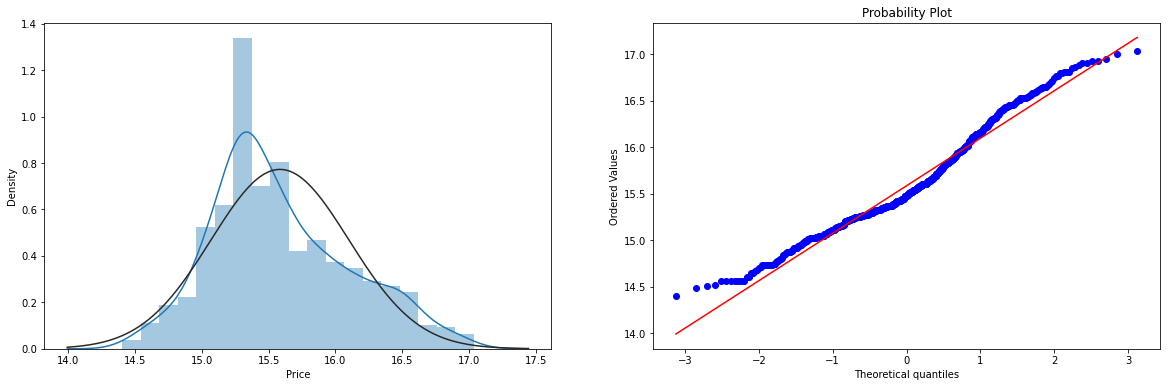

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))
sb.distplot(df2['Price'], fit=norm, ax=ax1)
res = stats.probplot(df2['Price'], plot=ax2)

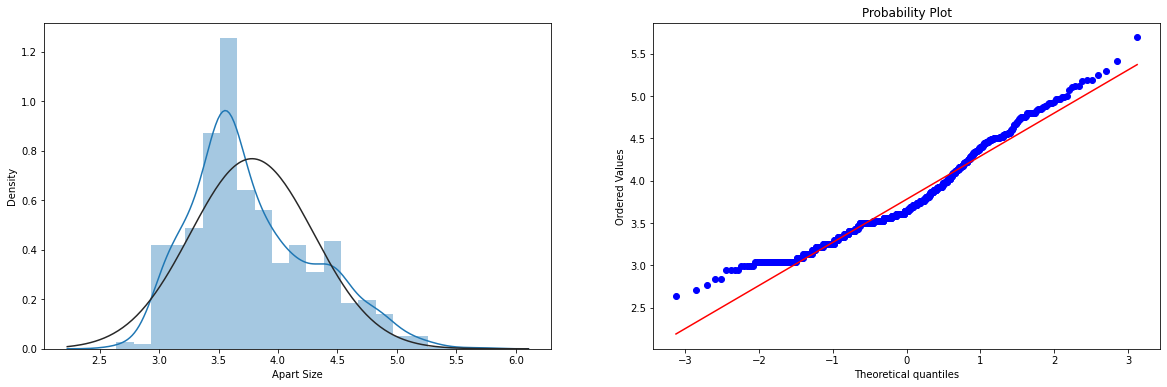

In [32]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))
sb.distplot(df2['Apart Size'], fit=norm, ax=ax1)
res = stats.probplot(df2['Apart Size'], plot=ax2)

## Testing Homoscedasticity

Homoscedasticity refers to the 'assumption that dependent variable(s) exhibit equal levels of variance across the range of predictor variable(s)'. Homoscedasticity is desirable because we want the error term to be the same across all values of the independent variables.

The best approach to test homoscedasticity for two metric variables is graphically. Departures from an equal dispersion are shown by such shapes as cones (small dispersion at one side of the graph, large dispersion at the opposite side) or diamonds (a large number of points at the center of the distribution).

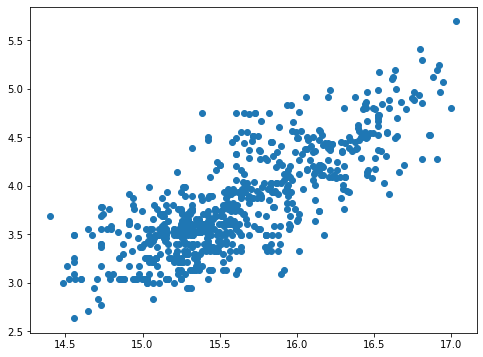

In [37]:
plt.subplots(figsize=(8, 6))
plt.scatter(df2['Price'], df2['Apart Size'])

As you can see the scatter plot doesn't have a conic shape anymore. Thats the power of normality. Just by ensuring normality in some variables, we can ensure homoscedasticity.

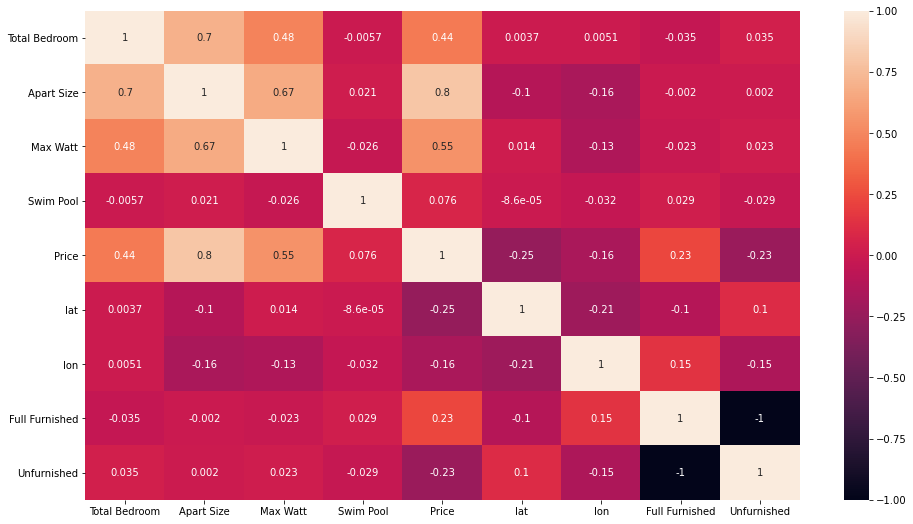

In [38]:
fig, ax = plt.subplots(figsize=(16, 9))
corr_matrix = df2.iloc[:, :12].corr()
sb.heatmap(data = corr_matrix, annot = True)
plt.show()

In [58]:
# Checkpoint
# df2.to_csv('travelio7.csv', index=True)
df2 = pd.read_csv('travelio7.csv', index_col=0)

## Feature Selection

In [59]:
df2.head()
X_var = df2.drop(columns= ['Name', 'lat', 'lon', 'Swim Pool', 'location', 'Address', 'Price'])
y = df2['Price']

X_var.describe()

,Total Bedroom,Apart Size,Max Watt,Full Furnished,Unfurnished,Cakung,Cempaka Putih,Cengkareng,Cilandak,Duren Sawit,...,Ps. Rebo,Pulo Gadung,Sawah Besar,Senen,Setiabudi,Taman Sari,Tambora,Tanah Abang,Tebet,Tj. Priok
count,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,...,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000
mean,1.347150,3.780989,2796.141192,0.922280,0.077720,0.007772,0.007772,0.025907,0.009067,0.003886,...,0.005181,0.069948,0.023316,0.036269,0.081606,0.006477,0.003886,0.068653,0.012953,0.012953
std,0.988234,0.519492,1881.756917,0.267904,0.267904,0.087873,0.087873,0.158960,0.094851,0.062257,...,0.071841,0.255225,0.151003,0.187081,0.273941,0.080269,0.062257,0.253027,0.113147,0.113147
min,0.000000,2.639057,900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,3.433987,1917.250000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,3.637586,2200.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.000000,4.110874,3500.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3.000000,5.693732,21000.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Train Test Split

I'm going to split the data into a test set and a training set. I will hold out the test set until the very end and use the error on those data as an unbiased estimate of how my models did.

I might perform a further split later on the training set into training set proper and a validation set or I might cross-validate.

In [60]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_var, y, test_size=0.2, random_state=27)

# 2. Model

## 2.0 Cross-Validation Routine

In [151]:
kf = KFold(n_splits=5, shuffle=True, random_state=27)

In [175]:
from sklearn.model_selection import KFold

# squared_loss
def rmse_cv(model):
    rmse = -cross_val_score(model, X_train, y_train, scoring="neg_root_mean_squared_error", cv = kf)
    return(rmse)

In [170]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=ShuffleSplit(n_splits=5, test_size=0.2, random_state=0), n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=27)
    if axes is None:
        _, axes = plt.subplots(figsize=(10, 8))

    axes.set_title(title)
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes.grid()
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes.legend(loc="best")

    return plt

In [169]:
def train_model(title, estimator):  
    cv = rmse_cv(estimator)
    cv_error = cv.mean()
    cv_std = cv.std()
    # fit
    estimator.fit(X_train, y_train)
    # predict
    y_train_pred = estimator.predict(X_train)
    training_error = np.sqrt(mean_squared_error(y_train, y_train_pred))
    train_r2 = r2_score(y_train, y_train_pred)

    y_test_pred = estimator.predict(X_test)
    test_error = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_r2 = r2_score(y_test, y_test_pred)
    
    # visualizing the result
    df = pd.DataFrame({'Model':title, '(RMSE) CV Error': cv_error, 'CV Std': cv_std, '(RMSE) Training error':training_error, '(RMSE) Test Error':test_error, '(R2) Training Score':train_r2, '(R2) Test Score':test_r2}, index=[0])
    return df

## 2.1 Linear Regression

In [176]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr_results = train_model('Linear Regression', lr)
lr_results

,Model,(RMSE) CV Error,CV Std,(RMSE) Training error,(RMSE) Test Error,(R2) Training Score,(R2) Test Score
0,Linear Regression,0.229457,0.016247,0.209983,0.217076,0.835861,0.817331


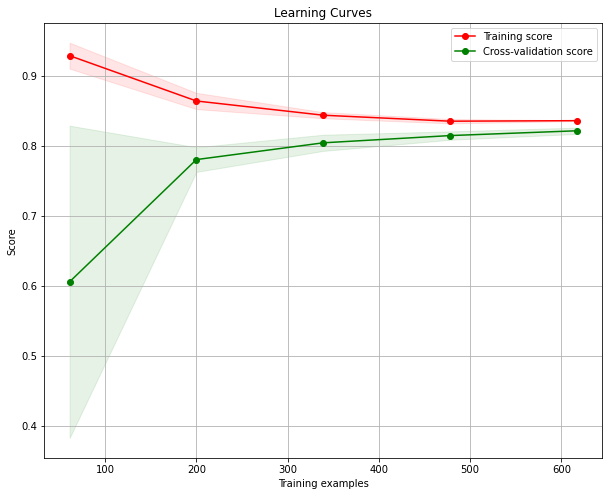

In [159]:
title = "Learning Curves"

estimator = lr
plot_learning_curve(estimator, title, X_var, y)

plt.show()

## 2.2 Random Forest Regressor

In [160]:
rf = RandomForestRegressor(max_depth = 6, random_state = 27)
rf_results = train_model('Random Forest Regressor [baseline]', rf)
rf_results

,Model,(RMSE) CV Error,CV Std,(RMSE) Training error,(RMSE) Test Error,(R2) Training Score,(R2) Test Score
0,Random Forest Regressor [baseline],0.24443,0.015315,0.202519,0.234036,0.847323,0.787672


### Hyperparameter Tuning

We will try to perfrom some hyperparameter tuning to see if we can improve our score on the test set

In [161]:
n_estimators = [int(x) for x in np.linspace(start = 100, stop=2000, num=20)]
max_features = [None, 'sqrt', 'log2']
max_depth = [np.arange(start = 3, stop = 16, step=1)]
max_depth.append(None)
min_samples_split = [2, 4, 5, 6, 7]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid ={'n_estimators': n_estimators,
        'max_features': max_features,
        'max_depth': max_depth,
        'min_samples_split': min_samples_split,
        'min_samples_leaf': min_samples_leaf,
        'bootstrap': bootstrap}

rf_random = RandomizedSearchCV(estimator=rf, cv = 5, param_distributions = random_grid, random_state=27, n_jobs=-1, verbose=0)
rf_random.fit(X_train, y_train)
rf_random.best_params_

{'n_estimators': 1700,
 'min_samples_split': 7,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': None,
 'bootstrap': False}

In [177]:
best_random = rf_random.best_estimator_
rf_best_results = train_model('Random Forest [optimized]', best_random)
rf_best_results

,Model,(RMSE) CV Error,CV Std,(RMSE) Training error,(RMSE) Test Error,(R2) Training Score,(R2) Test Score
0,Random Forest [optimized],0.217775,0.009606,0.103904,0.203305,0.959811,0.839772


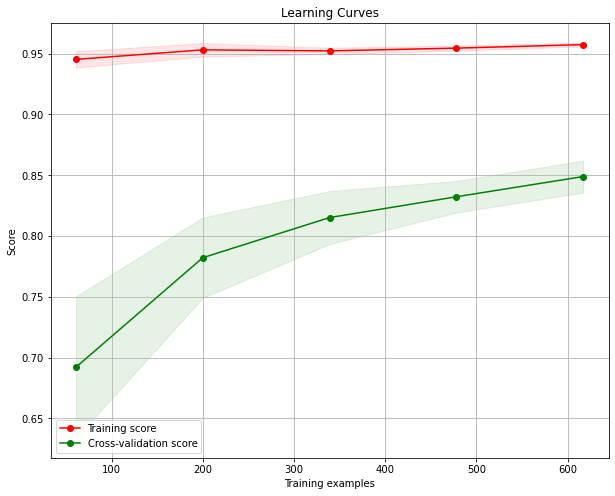

In [163]:
title = "Learning Curves"

estimator = best_random
plot_learning_curve(estimator, title, X_var, y)

plt.show()

If we take a look at the curve we can see that the trend shows an increasing validation score, if we have more data we might be able to get it close to the training score. This is one of the downside of working with limited data on ensemble model.

## 2.3 XGBoost Regressor

In [155]:
xgb = XGBRegressor(verbosity = 0, random_state = 27)
xgb_results = train_model('XGBRegressor [baseline]', xgb)
xgb_results

,Model,(RMSE) CV Error,CV Std,(RMSE) Training error,(RMSE) Test Error,(R2) Training Score,(R2) Test Score
0,XGBRegressor [baseline],0.224384,0.009016,0.071544,0.228214,0.980946,0.798104


In [66]:
d = {'Learning Rate':[],
            'Mean CV Error': [],
            'CV Error Std': [],
            'Training Error': []}
for lr in np.arange(start= 0.05, stop=0.35, step=0.05):
    xgb = XGBRegressor(n_estimators=500, learning_rate=lr, early_stopping=5)
    cv_res = rmse_cv(xgb)
    xgb.fit(X_train, y_train)
    y_train_pred = xgb.predict(X_train)
    d['Learning Rate'].append(lr)
    d['Mean CV Error'].append(cv_res.mean())
    d['CV Error Std'].append(cv_res.std())
    d['Training Error'].append(np.sqrt(mean_squared_error(y_train, y_train_pred)))

xgb_tuning_1 = pd.DataFrame(d)
xgb_tuning_1

,Learning Rate,Mean CV Error,CV Error Std,Training Error
0,0.05,0.216038,0.011774,0.092352
1,0.10,0.225486,0.007819,0.058462
2,0.15,0.228645,0.005337,0.052823
3,0.20,0.227991,0.003771,0.051646
4,0.25,0.228967,0.006944,0.051581
5,0.30,0.231707,0.005858,0.051467


In [ ]:
xgb_tuning_2 = pd.DataFrame(d)
xgb_tuning_2
print('Optimal parameter values are: ')
best = xgb_tuning_2.iloc[xgb_tuning_2.idxmin()['Mean CV Error']]
print('max_depth: {}'.format(int(best['max_depth'])))
print('min_child_weight: {}'.format(int(best['min_child_weight'])))

Optimal parameter values are: 
max_depth: 3
min_child_weight: 1


In [67]:
d = {'max_depth':[],
             'min_child_weight': [],
            'Mean CV Error': [],
            'CV Error Std': [],
            'Training Error': []}

params2 = {'max_depth': list(range(3,10,2)), 'min_child_weight': list(range(1,6,2))}

for md in params2['max_depth']:
    for mcw in params2['min_child_weight']:
        xgb_model = XGBRegressor(n_estimators=1000, learning_rate=0.05, early_stopping=5, max_depth=md, min_child_weight=mcw )
        cv_res = rmse_cv(xgb_model)
        xgb_model.fit(X_train, y_train)
        y_train_xgb = xgb_model.predict(X_train)
        d['max_depth'].append(md)
        d['min_child_weight'].append(mcw)
        d['Mean CV Error'].append(cv_res.mean())
        d['CV Error Std'].append(cv_res.std())
        d['Training Error'].append(np.sqrt(mean_squared_error(y_train_xgb, y_train)))

In [180]:
n_estimators = np.arange(500, 1100, 100)
learning_rate = np.arange(0.05, 0.35, 0.05)
max_depth = np.arange(3,10,2)
min_child_weight = np.arange(1,6,2)

param_grid = dict(n_estimators=n_estimators, learning_rate=learning_rate, max_depth = max_depth, min_child_weight = min_child_weight)

xgb_random = RandomizedSearchCV(estimator=xgb, cv = kf, param_distributions = param_grid, scoring = 'neg_root_mean_squared_error', random_state=27, n_jobs=-1)
xgb_random.fit(X_train, y_train)
xgb_random.best_params_

{'n_estimators': 800,
 'min_child_weight': 1,
 'max_depth': 3,
 'learning_rate': 0.05}

In [181]:
xgb_best = xgb_random.best_estimator_
xgb_best_results = train_model('XGBRegressor [optimized]', xgb_best)
xgb_best_results

,Model,(RMSE) CV Error,CV Std,(RMSE) Training error,(RMSE) Test Error,(R2) Training Score,(R2) Test Score
0,XGBRegressor [optimized],0.208752,0.017149,0.133361,0.205716,0.933794,0.835949


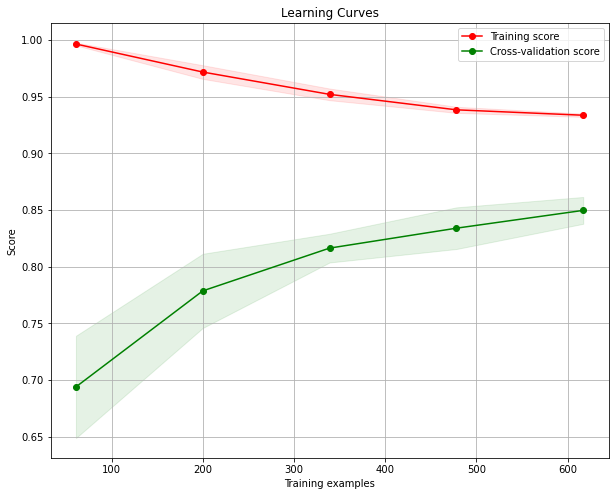

In [182]:
title = "Learning Curves"

estimator = xgb_best
plot_learning_curve(estimator, title, X_var, y)

plt.show()

Based on the curve trend we can see that there is still potential for the training and validation/test score to improve given more data just like our Random Forest.

## 2.4 Gradient Boosting

In [183]:
gb = GradientBoostingRegressor(random_state = 27) 
gbr_results = train_model('Gradient Boosting', gb)
gbr_results

,Model,(RMSE) CV Error,CV Std,(RMSE) Training error,(RMSE) Test Error,(R2) Training Score,(R2) Test Score
0,Gradient Boosting,0.220045,0.013427,0.172792,0.21274,0.888855,0.824556


### Hyperparameter Tuning

In [184]:
learning_rate = np.arange(start= 0.05, stop=0.2, step=0.01)
n_estimators = np.arange(start = 100, stop = 2050, step=50)
max_depth = [x for x in np.linspace(1, 10, num=10)]
min_samples_split = [2, 4, 5, 6, 7]
min_samples_leaf = [1, 2, 4]
max_features = [None, 'sqrt', 'log2']



random_grid ={}

random_grid = {
                'learning_rate':learning_rate,
                'n_estimators': n_estimators,
                'max_depth': max_depth,
                'max_features': max_features,
                'min_samples_split':min_samples_split,
                'min_samples_leaf':min_samples_leaf
              }
gb_random = RandomizedSearchCV(estimator=gb, cv = kf, param_distributions = random_grid, scoring = 'neg_root_mean_squared_error', random_state=27, n_jobs=-1)
gb_random.fit(X_train, y_train)
gb_random.best_params_

{'n_estimators': 650,
 'min_samples_split': 6,
 'min_samples_leaf': 1,
 'max_features': 'log2',
 'max_depth': 4.0,
 'learning_rate': 0.07}

In [185]:
gb_best = gb_random.best_estimator_
gb_best_results = train_model('Gradient Boosting [optimized]', gb_best)
gb_best_results

,Model,(RMSE) CV Error,CV Std,(RMSE) Training error,(RMSE) Test Error,(R2) Training Score,(R2) Test Score
0,Gradient Boosting [optimized],0.215909,0.013687,0.104709,0.197649,0.959186,0.848563


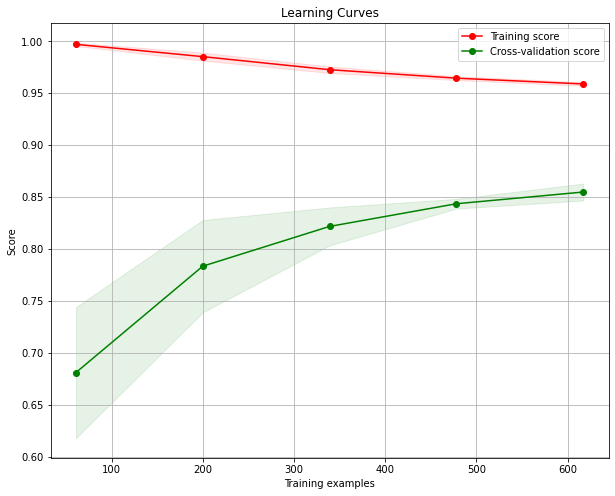

In [186]:
title = "Learning Curves"

estimator = gb_best
plot_learning_curve(estimator, title, X_var, y)

plt.show()

Similar to other ensemble model learning curve we can see an increasing trend in our validation score, given more data the accuracy might improve even more. But. even so this model yielded the highest accuracy so far.

## 2.5 Ridge Regression

In [187]:
ridge_alphas = [1e-15, 1e-10, 1e-8, 9e-4, 7e-4, 5e-4, 3e-4, 1e-4, 1e-3, 5e-2, 1e-2, 0.1, 0.3, 1, 3, 5, 10, 15, 18, 20, 30, 50, 75, 100]
ridge = Ridge(random_state = 27)

ridge_rob = make_pipeline(RobustScaler(), RidgeCV(alphas=ridge_alphas, cv=kf))

ridge_rob_results = train_model('Ridge Regression (rob)', ridge_rob)
ridge_rob_results

,Model,(RMSE) CV Error,CV Std,(RMSE) Training error,(RMSE) Test Error,(R2) Training Score,(R2) Test Score
0,Ridge Regression (rob),0.230955,0.016572,0.211195,0.216493,0.833961,0.81831


In [188]:
ridge_norm = make_pipeline(MinMaxScaler(), RidgeCV(alphas=ridge_alphas, cv=kf))
ridge_norm_results = train_model('Ridge Regression (norm)', ridge_norm)
ridge_norm_results

,Model,(RMSE) CV Error,CV Std,(RMSE) Training error,(RMSE) Test Error,(R2) Training Score,(R2) Test Score
0,Ridge Regression (norm),0.229402,0.015968,0.210444,0.216502,0.835139,0.818296


In [189]:
ridge_std = make_pipeline(StandardScaler(), RidgeCV(alphas=ridge_alphas, cv=kf))
ridge_std_results = train_model('Ridge Regression (std)', ridge_std)
ridge_std_results

,Model,(RMSE) CV Error,CV Std,(RMSE) Training error,(RMSE) Test Error,(R2) Training Score,(R2) Test Score
0,Ridge Regression (std),0.229708,0.016488,0.21007,0.217024,0.835726,0.817418


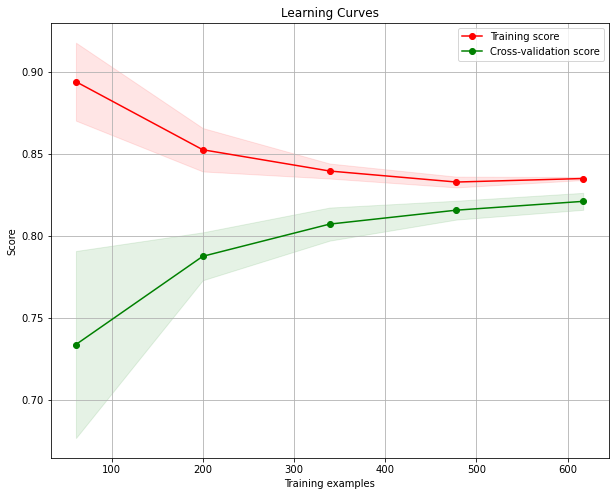

In [190]:
title = "Learning Curves"

estimator = ridge_rob
plot_learning_curve(estimator, title, X_var, y)
    
plt.show()

In [191]:
pd.concat([lr_results, rf_best_results, xgb_best_results, gb_best_results, ridge_rob_results], axis=0, ignore_index=True)

,Model,(RMSE) CV Error,CV Std,(RMSE) Training error,(RMSE) Test Error,(R2) Training Score,(R2) Test Score
0,Linear Regression,0.229457,0.016247,0.209983,0.217076,0.835861,0.817331
1,Random Forest [optimized],0.217775,0.009606,0.103904,0.203305,0.959811,0.839772
2,XGBRegressor [optimized],0.208752,0.017149,0.133361,0.205716,0.933794,0.835949
3,Gradient Boosting [optimized],0.215909,0.013687,0.104709,0.197649,0.959186,0.848563
4,Ridge Regression (rob),0.230955,0.016572,0.211195,0.216493,0.833961,0.818310


Comparing all these different models we can see that **XGBRegressor** showed the best result with a CV error of 0.208752, the reason I picked this model even though **Random Forest** and **Gradient Boosting** showed a better test score and error is because we don't want to select model based on our test performance, if we did that it would mean that our model overfit the test data since it may have a better performance due to chance alone. It's best practice to perform any sort of model selection based on our CV error since it is more representative of our model generalization capability.

The performance on the test set should only then be use as a true out of sample performance metric once we've selected our model. Based on the difference in training and test performance we can also see that there is a high variance in our model due to the lack of data, this is further supported by the trend on the learning curve where the test score are still increasing alongside with the number of training data.

# Exporting Model

In [192]:
s = pd.Series()
s = df2['Price'].copy()

In [197]:
def predict_price(bedroom, apt_size, max_watt, furnish_type, kecamatan):    
    loc_index = np.where(X_var.columns==kecamatan)[0][0]
    furnish_index = np.where(X_var.columns==furnish_type)[0][0]

    x = np.zeros(len(X_var.columns))
    x[0] = bedroom
    x[1] = np.log(apt_size)
    x[2] = max_watt    
    x[loc_index] = 1    
    x[furnish_index] = 1

    #  Make Prediction
    y_pred = xgb_best.predict(np.array([x]))
    # Reverse log transform predicted price value 
    return float(np.exp(y_pred))

In [199]:
print(predict_price(2, 85, 10600, 'Full Furnished', 'Setiabudi'))
print(predict_price(1, 102, 5600, 'Unfurnished', 'Pancoran'))

8257322.5
12190411.0


In [200]:
import pickle
with open('travelio_apart.pickle','wb') as f:
    pickle.dump(xgb_best,f)

In [58]:
import json
columns = {
    'data_columns' : [col.lower() for col in X_var.columns]
}
with open("columns.json","w") as f:
    f.write(json.dumps(columns))